### Visualizing and Evaluating Results

In [2]:
import json
import pickle
import numpy as np
# from utils import *
from pprint import pprint
from scipy.stats import sem
from statistics import mean, stdev
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
%matplotlib inline
colors = ['royalblue', 'seagreen', 'coral', 'darkorchid', 'gray', 'gold']
hatches = ['//', '||', '--', 'xx', 'oo', r'\\']

# fig_dir = get_full_path("MTL", "Figures")

In [3]:
""" File/dictionary serialization using pickle. """

def save(d, filename):
    """ Serialize a dictionary or object d. """
    with open(f'data/{filename}.pickle', 'wb') as f:
        pickle.dump(d, f, protocol=pickle.HIGHEST_PROTOCOL)

def load(filename):
    """ Load a previously serialized object from disk. """
    with open(f'data/{filename}.pickle', 'rb') as f:
        return pickle.load(f)
    
""" File/dictionary serialization using JSON. """

def j_save(d, filename):
    """ Serialize a dictionary or list d. """
    with open(f'data/{filename}.json', 'wb') as f:
        json.dump(d, f, indent=2)

def j_load(filename):
    """ Load a previously serialized object from disk. """
    with open(f'data/{filename}.json', 'rb') as f:
        return json.load(f)

In [82]:
tasks = ['loss', 'congestion', 'noise']

""" CAIDA Baseline """
stl = j_load("stl_results_latest") # best CAIDA STL
mtl = load("CAIDA_scores") # CAIDA original (loss, congestion, noise)


""" RIPE Atlas """

# stl = j_load("ripe_stl")
# mtl = load("ripe_mtl") # time: 80.109 seconds, stdev: 1.220s



try:
    stl['loss'] = stl.pop('outage')
except:
    pass

""" Single Task Analysis: """
stl_stdev = 0
for t in tasks:
    if 'query' in t:
        continue
    dataset = "Test" # could also use 'Validation'
    scores = [a[0] for a in stl[t][dataset]]
    times = [a[1] for a in stl[t][dataset]]
    val_times = [a[1] for a in stl[t]["Validation"]]

    stl[f"{t}_mean_score"] = mean(scores)
    stl[f"{t}_mean_times"] = mean(times) + mean(val_times)
    stl[f"{t}_stdev"] = stdev(scores)
    stl[f"{t}_stderr"] = sem(scores)
    stl[f"{t}_time_stderr"] = sem(times)
        
    print(f"STL '{t}' Mean Score : {round(stl[f'{t}_mean_score'], 5)}; \t\tscore std. dev: {round(stl[t + '_stdev'], 5)}")
    print(f"\tSTL '{t}' avg. time : {round(stl[f'{t}_mean_times'], 5)};\ttimes std. dev: {round(stdev(times), 4)}s")
    print(f"\tSTL '{t}' Std. Error : {round(stl[f'{t}_stderr'], 5)}")
    print(f"\tSTL '{t}' Time Std. Error : {round(stl[f'{t}_time_stderr'], 5)}")
    try:
        stl[t]['time_stdev'] = stdev(times)
        stl_stdev += stdev(times) * stdev(times)
    except:
        stl[t] = {}
        stl[t]['time_stdev'] = stdev(times)
        stl_stdev += stdev(times) * stdev(times)
#     print("variance:", round(stdev(times) * stdev(times), 5))
    print()
print(f"STL time std. dev: {round(math.sqrt(stl_stdev), 5)}")
print('_'*30, '\n')


""" Multi Task Analysis: """
mtl_times = []
mtl_scores = {task : [] for task in tasks}

for i in mtl:
    dataset = 'test' # could also be 'train' or 'valid'
    for j in mtl[i]['Scores'].keys():
        if dataset not in j:
            continue # only want 'test', 'valid', or 'train' datasets
        task = j.split('_')[0] # congestion, noise, loss, or changepoint
        
        try:
            mtl_scores[task].append(mtl[i]['Scores'][j])
        except:
            continue
    
    mtl_times.append(mtl[i]['Time'])
    
for task in tasks:
    mtl[f"{task}_mean_score"] = mean(mtl_scores[task])
    mtl[f"{task}_stdev"] = stdev(mtl_scores[task])
    
    mtl[f"{task}_stderr"] = sem(mtl_scores[task])
#     print(f"{task} stderr: {sem(mtl_scores[task])}")
    
    
    print(f"MTL '{task}' Mean Score:", round(mtl[f"{task}_mean_score"], 5), f"\tstd. dev: {round(mtl[f'{task}_stdev'], 5)}")
print(f"\tMTL avg. time: {round(mean(mtl_times), 5)};\tstd. dev: {round(stdev(mtl_times),3)}s")

mtl['time_stdev'] = stdev(mtl_times)


STL 'loss' Mean Score : 0.5395; 		score std. dev: 0.11305
	STL 'loss' avg. time : 367.72356;	times std. dev: 15.9218s
	STL 'loss' Std. Error : 0.05652
	STL 'loss' Time Std. Error : 7.96091

STL 'congestion' Mean Score : 0.606; 		score std. dev: 0.12193
	STL 'congestion' avg. time : 344.01962;	times std. dev: 0.9909s
	STL 'congestion' Std. Error : 0.06096
	STL 'congestion' Time Std. Error : 0.49545

STL 'noise' Mean Score : 0.577; 		score std. dev: 0.11759
	STL 'noise' avg. time : 335.81033;	times std. dev: 4.9161s
	STL 'noise' Std. Error : 0.0588
	STL 'noise' Time Std. Error : 2.45806

STL time std. dev: 16.69295
______________________________ 

MTL 'loss' Mean Score: 0.99463 	std. dev: 0.00458
MTL 'congestion' Mean Score: 0.979 	std. dev: 0.04462
MTL 'noise' Mean Score: 0.98029 	std. dev: 0.03032
	MTL avg. time: 34.89506;	std. dev: 0.215s


In [83]:
#### CAIDA
CAIDA_CONG_ORCE = [0.6334310850439883, 0.6383526383526383, 0.6453576864535768, 0.6409495548961425, 0.6479750778816199]
CAIDA_CONG_EE   = [0.6354319180087847, 0.6418485237483954, 0.6443768996960486, 0.6389301634472511, 0.6479750778816199]
CAIDA_CONG_MEAN2SD = [0.930131004,0.963106796,0.20242915,0.963963964,0.935483871,0.934831461,0.940509915,0.312312312,0.222222222,0.228813559,0.209090909,0.114583333,0.917525773,0.13592233,0.257627119]

CAIDA_LOSS_ORCE = [0.6334310850439883, 0.6277561608300908, 0.6453576864535768, 0.642962962962963, 0.64375]
CAIDA_LOSS_MEAN2SD = [0.631424375917768, 0.6348387096774193, 0.6381679389312976, 0.642962962962963]
CAIDA_LOSS_EE = [0.621301775147929, 0.6348387096774193, 0.636923076923077, 0.642962962962963, 0.6416275430359938]

CAIDA_NOISE_ORCE = [0.9190371991247265, 0.9409448818897638, 0.20224719101123595, 0.9429824561403509, 0.9324009324009325]
CAIDA_NOISE_EE = [0.9159292035398231, 0.9443378119001918, 0.21875, 0.9686098654708519, 0.9406392694063926]
CAIDA_NOISE_MEAN2SD = [0.9315673289183223, 0.9534883720930233, 0.23703703703703702, 0.9619686800894856, 0.9411764705882353]

# print([(sem(i)) for i in [CAIDA_CONG_ORCE, CAIDA_CONG_EE, CAIDA_CONG_MEAN2SD]])
# print([(sem(i)) for i in [CAIDA_LOSS_ORCE, CAIDA_LOSS_EE, CAIDA_LOSS_MEAN2SD]])
# print([(sem(i)) for i in [CAIDA_NOISE_ORCE, CAIDA_NOISE_EE, CAIDA_NOISE_MEAN2SD]])

In [116]:
#### RIPE (I just didn't want to rename variables)
CAIDA_CONG_ORCE = [0.6801736613603473, 0.6847360912981454, 0.7111111111111111, 0.6755162241887906, 0.6562986003110419,0, 0, 0.399]
CAIDA_CONG_EE   = [0.6782608695652174, 0.6847360912981454, 0.7111111111111111, 0.6755162241887906, 0.6573208722741433, 0, 0, 0.406]
CAIDA_CONG_MEAN2SD = [0.6812227074235808, 0.6847360912981454, 0.7091988130563799, 0.6765140324963071, 0.6562986003110419, 0, 0, .336, .326]

CAIDA_LOSS_ORCE = [0.6801736613603473, 0.6827880512091039, 0.7130177514792899, 0.6755162241887906, 0.6562986003110419, 0 ,0]
CAIDA_LOSS_EE = [0.6801736613603473, 0.6827880512091039, 0.7130177514792899, 0.6755162241887906, 0.6552795031055901, 0, 0, 0.343]
CAIDA_LOSS_MEAN2SD = [0.6801736613603473, 0.6827880512091039, 0.7130177514792899, 0.6755162241887906, 0.6552795031055901, 0, 0, 0.7343532684283727]

CAIDA_NOISE_ORCE = [0.008097166,0.763116057,0.031746032,0,0.009009009,0.966542751,0,0.979127135,0,0.954643629,0.85,0.016,0.962184874,0.87732342, 0.884540117,]
CAIDA_NOISE_EE = [0.008196721,0.760697306,0.979423868,0.965811966,0,0,0.965092402,0.982857143,0.008333333,0.967320261,0.854578097,0.016064257,0.970338983,0.888888889,0.008230453,0.015444015,0 ,0]
CAIDA_NOISE_MEAN2SD = [0.951417004,0,0.975308642,0.008547009,0,0.964749536,0.959183673,0,0.008064516,0.008438819,0,0.016,0.008130081,0.895635674,0.008298755,0.015384615,0.965065502,0.008849558,0.972515856,0.007722008,0.00754717,0.979020979,0.98467433,0.978354978,0.976833977,0.007490637,0.956349206,0,0.973282443,0.974137931,0.970479705,0.007220217,0.007905138,0,0,0.971659919,0.958174905,0,0.015209125,0.007782101,0.965235174,0,0.966601179,0.925,0,0.861878453,0.008230453,0.905454545,0.007633588,0.972860125,0.972043011,0.017167382,0.016260163,0,0.960334029,0.96359743,0.935361217,0,0,0.015625,0.975510204,0,0.015384615,0,0.007936508,0.021276596,0.981132075,0.864768683,0,0.973084886,0.715151515,0.007326007,0.860294118,0.813559322,0.008298755,0.960629921,0.015748031,0,0.957403651,0,0.00896861,0.008097166,0.95481336,0.973947896,0.963265306,0.909090909,0.008,0.965116279,0.980916031,0,0.974854932,0.941883768,0.985263158,0,0.959064327,0,0,0.95154185,0,0.743633277]

print([(mean(i)) for i in [CAIDA_CONG_ORCE, CAIDA_CONG_EE, CAIDA_CONG_MEAN2SD]])
print([(mean(i)) for i in [CAIDA_LOSS_ORCE, CAIDA_LOSS_EE, CAIDA_LOSS_MEAN2SD]])
print([(sem(i)) for i in [CAIDA_NOISE_ORCE, CAIDA_NOISE_EE, CAIDA_NOISE_MEAN2SD]])

[0.47585446103367957, 0.476618146054676, 0.4522189160650506]
[0.4868277555069391, 0.46872189891789023, 0.5176410574714368]
[0.12018771431347589, 0.11223613525787995, 0.04719992285945686]


In [117]:
numGroups = 5

stl_means, mtl_means = [], []
stl_stdevs, mtl_stdevs = [], []
stl_stderr, mtl_stderr = [], []
stl_times = []
stdevs, data, stderrs = [], [], []
rects = {}
FONTSIZE = 14

data.append([
    mean(CAIDA_LOSS_ORCE),
    mean(CAIDA_LOSS_EE),
    mean(CAIDA_LOSS_MEAN2SD),
    stl[f'loss_mean_score'],
    mtl[f'loss_mean_score']
])

data.append([
    mean(CAIDA_CONG_ORCE),
    mean(CAIDA_CONG_EE),
    mean(CAIDA_CONG_MEAN2SD),
    stl[f'congestion_mean_score'],
    mtl[f'congestion_mean_score']
])

data.append([
    mean(CAIDA_NOISE_ORCE),
    mean(CAIDA_NOISE_EE),
    mean(CAIDA_NOISE_MEAN2SD),
    stl[f'noise_mean_score'],
    mtl[f'noise_mean_score']
])

# print(data)

# data.append([stl[f'{t}_mean_score'], mtl[f'{t}_mean_score']])
# stdevs.append([stl[f'{t}_stdev'], mtl[f'{t}_stdev']])
stderrs.append([
    sem(CAIDA_LOSS_ORCE),
    sem(CAIDA_LOSS_EE),
    sem(CAIDA_LOSS_MEAN2SD),
    stl[f'loss_stderr'],
    mtl[f'loss_stderr']
])

stderrs.append([
    sem(CAIDA_CONG_ORCE),
    sem(CAIDA_CONG_EE),
    sem(CAIDA_CONG_MEAN2SD),
    stl[f'congestion_stderr'],
    mtl[f'congestion_stderr']
])

stderrs.append([
    sem(CAIDA_NOISE_ORCE),
    sem(CAIDA_NOISE_EE),
    sem(CAIDA_NOISE_MEAN2SD),
    stl[f'noise_stderr'],
    mtl[f'noise_stderr']
])

# print(stderrs)

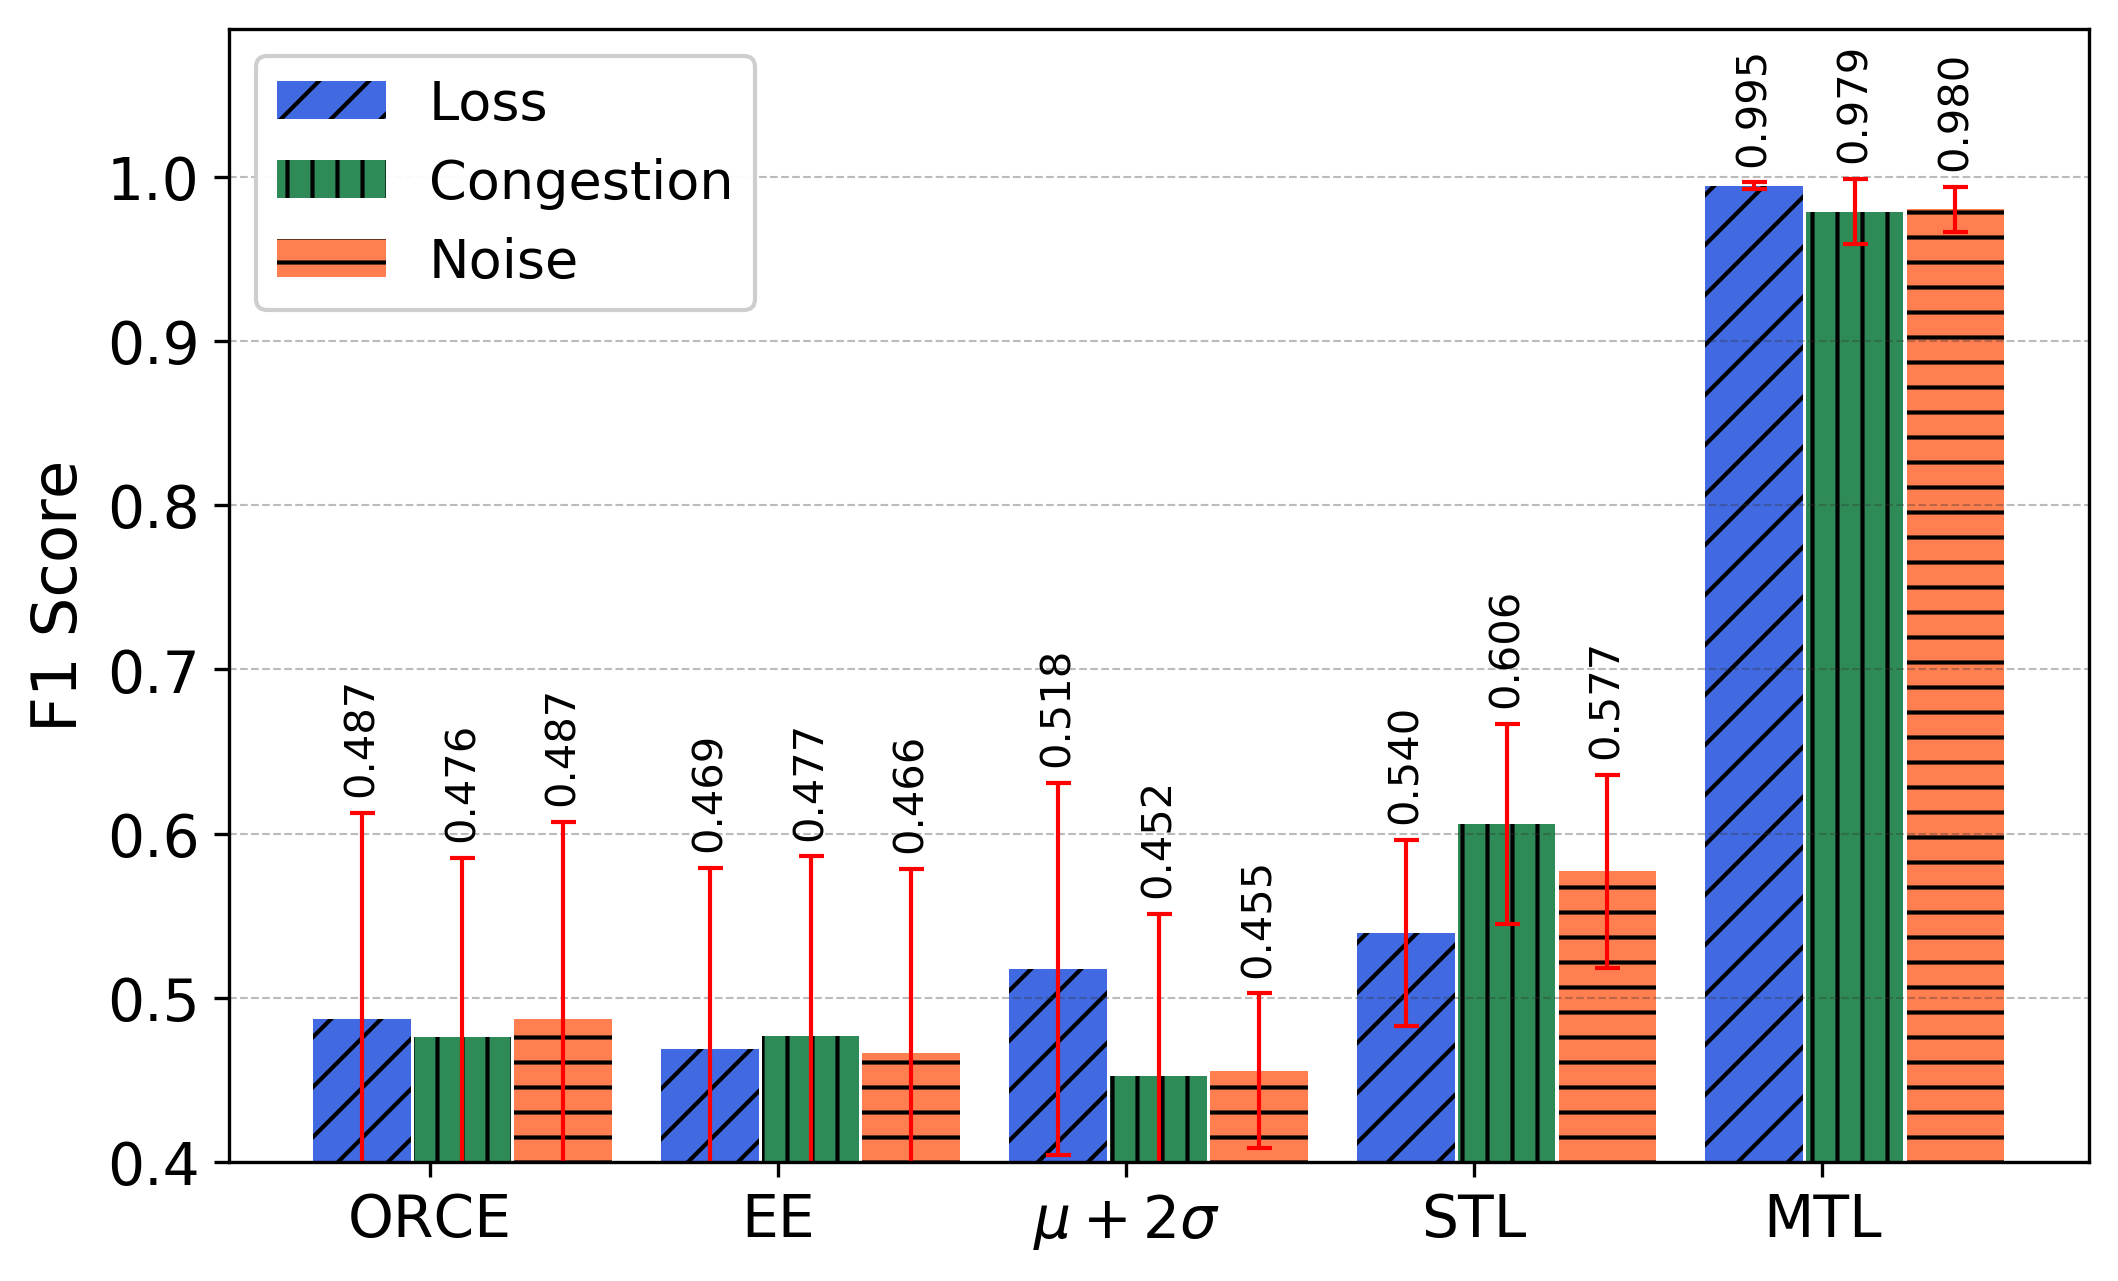

In [120]:
ind = np.arange(numGroups) # x locations for the groups

margin = 0.009 # space between the bars

fig = plt.figure(figsize=(8, 5)) # good for all queries
ax = fig.add_subplot(111)

width = 0.28

for i in range(len(data)):
    showError = True
    if showError:
        thickness = 1
        rects[i] = ax.bar(ind + (width * i) + (margin * i), data[i], width, color=colors[i], yerr=stderrs[i], hatch=hatches[i], \
                         error_kw=dict(ecolor='red', lw=thickness, capsize=3, capthick=thickness))
    else:
        rects[i] = ax.bar(ind + (width * i) + (margin * i), data[i], width, color=colors[i], hatch=hatches[i])

        
fntsize = 13    
LOC = "upper left"
    
ax.legend( (rects[0], rects[1], rects[2]), ('Loss', 'Congestion', 'Noise'), \
            loc=LOC, framealpha=0.95, fontsize=fntsize )


ax.set_ylabel('F1 Score', fontsize=FONTSIZE + 1)
ax.set_xticks(ind + (width * ((len(tasks) - 1) / 3)) + margin)

ax.set_xticklabels( ('ORCE', 'EE', '$\mu+2\sigma$', 'STL', 'MTL'))

plt.grid(color='#333333', linestyle='--', linewidth=0.5, axis='y', alpha=0.33)
fig.set_dpi(300)

ax.tick_params(axis='both', labelsize=FONTSIZE)
# SMALL_SIZE = 8
# plt.rc('xtick', labelsize=SMALL_SIZE)
# plt.rc('ytick', labelsize=SMALL_SIZE)


LB, UB = (0.4, 1.09)

def autolabel(rects, index):
    """
    Attach a text label above each bar displaying its height
    """
    for i in range(len(rects)):
        rect = rects[i]
        height = rect.get_height()
        
        myError = stderrs[index][i]
        
        margin = 0.01
        # margin = 0.0025
        
        if height >= LB:
            ax.text(rect.get_x() + rect.get_width() / 2, height + myError + margin,
                    f'{round(height, 3):.3f}',
                    ha='center', va='bottom', fontsize=10, rotation=90)

[autolabel(rects[i], i) for i in range(len(tasks))] # use this to add the numerical score above each bar

ax.set_ylim([LB, UB]) # lower, upper bounds of the y-axis

# plt.savefig("Figures/naive_caida.png", bbox_inches="tight")
plt.savefig("Figures/naive_ripe.png", bbox_inches="tight")

plt.show()

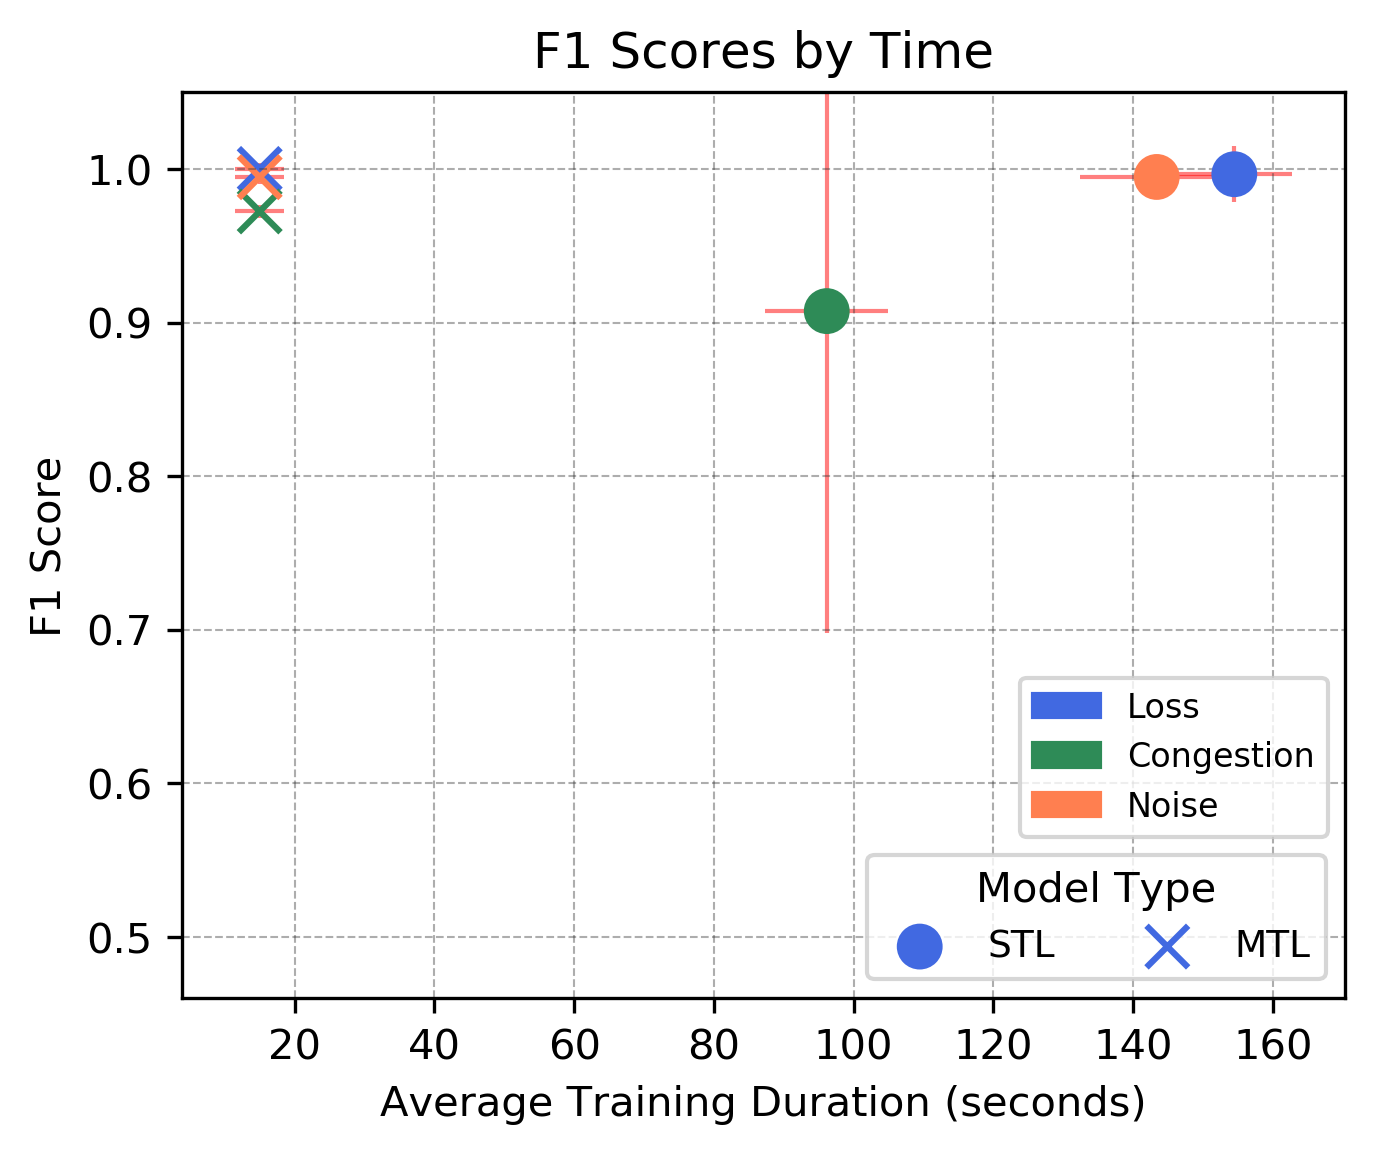

In [28]:
x1, x2 = [], [] # list of x-values (times)
y1, y2 = [], [] # list of y-values (F1 scores)
mtl_score_errs, stl_time_errs, stl_score_errs = [], [], []

for t in tasks:
    y1.append(stl[f'{t}_mean_score'])
    y2.append(mtl[f'{t}_mean_score'])
    
    x1.append(stl[f'{t}_mean_times'])
    x2.append(mean(mtl_times))
    
#     try:
    stl_time_errs.append(stl[t]['time_stdev'])
    stl_score_errs.append(stl[f'{t}_stdev'])
#     except:
#         stl_time_errs.append(0)
#         stl_score_errs.append(0)
    mtl_score_errs.append(mtl[f'{task}_stdev'])
    

fig, ax = plt.subplots(1, 1, figsize=(5, 4))

ax.set_xlabel('Average Training Duration (seconds)')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Scores by Time')


drawXerror, drawYerror = (True, True)
z = 0
a = 0.5

if drawXerror and drawYerror:
    ax.errorbar(x1, y1, xerr=stl_time_errs, yerr=stl_score_errs, fmt='o', ecolor='red', \
                color='None', alpha=a, elinewidth=1, zorder=z)
    ax.errorbar(x2, y2, xerr=mtl['time_stdev'], yerr=mtl_score_errs, fmt='o', ecolor='red', \
                color='None', alpha=a, elinewidth=1, zorder=z)
elif drawXerror:
    ax.errorbar(x1, y1, xerr=stl_time_errs, fmt='o', ecolor='red', \
                color='None', alpha=a, elinewidth=1, zorder=z)
    ax.errorbar(x2, y2, xerr=mtl['time_stdev'], fmt='o', ecolor='red', \
                color='None', alpha=a, elinewidth=1, zorder=z)
elif drawYerror:
    ax.errorbar(x1, y1, yerr=mtl_score_errs, fmt='o', ecolor='red', \
                color='None', alpha=a, elinewidth=1, zorder=z)
    ax.errorbar(x2, y2, yerr=mtl_score_errs, fmt='o', ecolor='red', \
                color='None', alpha=a, elinewidth=1, zorder=z)

    
scatter = ax.scatter(x1, y1, c=colors[:len(tasks)], marker="o", s=100, zorder=10)
scatter2 = ax.scatter(x2, y2, c=colors[:len(tasks)], marker="x", s=100)



# ax.set_ylim(0.9, 1.005) # lower, upper bounds of the y-axis
# ax.set_ylim(0.895, 1.005) # CAIDA bounds



if "ddos" in tasks:
    ax.set_ylim(0.45, 1.05) # RIPE 2
    legend1 = ax.legend(["STL", "MTL"], loc="lower left", ncol=2, title="Model Type", \
                    prop={'size': 9}) # LHS
    ax.add_artist(legend1)
    labels = ['Loss', 'Congestion', 'Noise', 'Changepoint', 'DDoS']
    
    handles = [mpatches.Patch(color=colors[labels.index(l)], label=l, ls="-") for l in labels]
    legend2 = ax.legend(handles, labels, loc="lower left", ncol=1, prop={'size': 8}, bbox_to_anchor=(0, .15)) # LHS
else:
    ax.set_ylim(0.46, 1.05) # RIPE
    legend1 = ax.legend(["STL", "MTL"], loc="lower right", ncol=2, title="Model Type", \
                        bbox_to_anchor=(1.0, 0.00), prop={'size': 9})
    ax.add_artist(legend1)
    labels = ['Loss', 'Congestion', 'Noise']
    
    handles = [mpatches.Patch(color=colors[labels.index(l)], label=l, ls="-") for l in labels]
    legend2 = ax.legend(handles, labels, loc="lower right", ncol=1, prop={'size': 8}, bbox_to_anchor=(1.0, 0.16)) # RHS


fig.set_dpi(300)
plt.grid(color='#333333', linestyle='--', linewidth=0.5, axis='both', alpha=0.4)

plt.show()